<a href="https://colab.research.google.com/github/sf3318/text-analysis-final/blob/main/final_project_sf3318.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Media Sentiment on AI Market
The idea for this project came upon me after seeing Nvidia’s stock price tank after the Quarter three earnings report. I have been following the stock since its last 10 for 1 stock split back in June of 2024, and it had always followed a consistent pattern: Nvidia beats quarter revenue projection and the stock skyrockets 5-10% in price the next day. However, after an initial jump in the after-hours trading, it pulled back when the market opened and even dropped by the time the market closed.

Across the articles I regularly read, coverage of AI often appears optimistic, with many outlets labeling Nvidia a “buy” or “strong buy.” This observation motivated my core research question: Is media sentiment toward AI becoming more negative as the market cools, or is there a lag between market performance and media coverage?

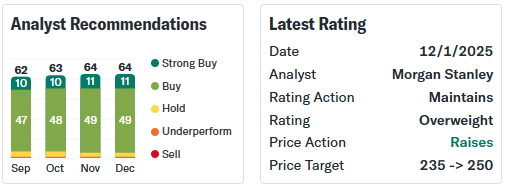

[(Analyst Recommendation for NVDA on Yahoo Finance on 12/6/2025)](https://finance.yahoo.com/quote/NVDA/)

For this project, I wanted to see what the general sentiment of AI is from the media. I understand that the sites I read on may be bias, and that I may not be getting a full and accurate reflection on how people feel about AI.
My hypothesis for the project is: given the recent downward trend with AI, news coverage should be leaning neutral to negative.
The market should reflect the health of the economy, and the health of the economy is ultimately run by the people. If there is a discrepancy between the market and the media, this may mean that the two parties are not on the same page, or a pattern of information asymmetry.


# DataFrame Creation and Scraping
To begin the process, I first needed to figure out what were the best topics to focus on. Originally, I had chosen the word AI. Using NewsAPI, I was able to scrape together a data frame consisting of title, author, description, and content. However, I realized using the term “AI” was too general as it was pulling articles from all different educational fields. To remedy this, I decided to specify my topics even more eventually coming up with five different topics:

**AI Regulation**: With AI regulation still developing around a rapidly emerging technology, I wanted to explore what people are saying about both the challenges and the potential opportunities involved in regulating AI.

**AI Risk and AI Safety:** By adding “Risk” and “Safety”, it narrows the search significantly, and instead of drawing articles that want to take advantage of the word “AI”, it addresses what I am trying to figure out.

**AI Governance and AI Accountability:** A big topic that has been prominent is AI hallucinations. A recent case that came up is with [Deloitte](https://fortune.com/2025/10/07/deloitte-ai-australia-government-report-hallucinations-technology-290000-refund/) publishing reports with AI hallucinations within them. While the fault is certainly on the employees who work with AI, as company’s push for a more inclusive AI policy, does that mean AI should be accountable as well?

Using these topics I then filtered through and got a more selective data frame.


In [ ]:
# Library Imports
import requests
import pandas as pd

!pip -q install requests tqdm


import requests
import pandas as pd
import json

!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

!pip install beautifulsoup4
from bs4 import BeautifulSoup

import plotly.express as px

!pip install scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

!pip install wordcloud
!pip install matplotlib
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import os
from getpass import getpass

In [ ]:
#Topics to search for
topics = ["AI regulation","AI risk", "AI Safety", "AI Governance", "AI Accountability"]

In [ ]:
#URL and API Key
base_url = "https://newsapi.org/v2/everything"

os.environ["API_Key"] = getpass("Paste your API Key: ")
api_key = os.environ.get("API_Key")

Paste your API Key: ··········


In [ ]:
def get_news(query, page_size = 100):
    url = base_url

    params = {"q": query,
              "pageSize": page_size,
              "language": "en",
              "apiKey": api_key
              }

    response = requests.get(url, params = params)
    data = response.json()

    articles = []
    for item in data.get("articles",[]):
        title = item["title"]
        author = item["author"]
        description = item["description"]
        content = item["content"]
        articles.append({"title": title, "author": author, "description":description, "content": content})

    return articles

In [ ]:
#Call topic list to run scraping

all_articles = []

for article in topics:
    article = get_news(topics)

all_articles.extend(article)

In [ ]:
#Creating DataFrame

df = pd.DataFrame(all_articles)
df.sample(10)

,title,author,description,content
0,Europe is scaling back its landmark privacy an...,"Robert Hart, Dominic Preston",After years of staring down the world’s bigges...,<ul><li></li><li></li><li></li></ul>\r\nThe EU...
86,Risks of AI in cybercrime take center stage at...,RT,Experts called for a stronger global response ...,Cybersecurity and artificial intelligence were...
5,‘I’m deeply uncomfortable’: Anthropic CEO warn...,Sasha Rogelberg,"Dario Amodei, who left OpenAI before founding ...",Anthropic CEO Dario Amodei doesnt think he sho...
48,Call Of Duty: Black Ops 7's Use Of AI Has US C...,staff@bgr.com (Daniel Trock),Artificial intelligence is starting to make mo...,Following the initial outcry from players in r...
82,Beta Film & Industry Execs Join Forces To Laun...,Stewart Clarke,EXCLUSIVE: Beta Film has teamed with a trio of...,EXCLUSIVE: Beta Film has teamed with a trio of...
9,30% of Doctors In UK Use AI Tools In Patient C...,BeauHD,An anonymous reader quotes a report from the G...,Almost three in 10 GPs in the UK are using AI ...
17,China wants to lead the world on AI regulation...,Elizabeth Gibney,Having placed artificial intelligence at the c...,Chinese president Xi Jinping speaking at the 2...
87,Is AI being shoved down your throat at work? H...,Sigal Samuel,Your Mileage May Vary is an advice column offe...,Your Mileage May Vary is an advice column offe...
67,Trump Withholding Billions In Grants From Stat...,Karl Bode,Hoping to repay corporate America’s feckless s...,from the zero-oversight-of-corporate-power dep...
15,There’s an AI Industry Civil War Brewing in D.C.,Ece Yildirim,A tale of two AI super PACs.,"To regulate or not to regulate, that’s the que..."


In [ ]:
#Cleaning up content section

def clean_up(x):
    x = x.replace("\n"," ").replace("\r"," ")
    soup = BeautifulSoup(x,"html.parser")
    return soup.get_text()


df["content"] = df["content"].apply(clean_up)

df = df.dropna()
df.sample(10)


,title,author,description,content
52,“It keeps me awake at night”: machine-learning...,"Davide Castelvecchi, Benjamin Thompson",Yoshua Bengio talks about his efforts to ident...,Bengio has pivoted his research to explore the...
63,"EU moves to ease AI, privacy rules amid pressu...",John Power,Bloc proposes delaying strict rules for 'high-...,The European Union has moved to scale back its...
53,Let a Thousand AI Regimes Bloom,Angela Huyue Zhang,While critics of decentralized technology regu...,While critics of decentralized technology regu...
60,Behold My ADD Maelstrom!,Kent Roberts,Personal Perspective: May I suggest replacing ...,"My instincts move in very distinct, no pun int..."
55,$150 Million AI Lobbying War Fuels The Fight O...,"Paulo Carvão, Contributor, \n Paulo Carvão, Co...",The $150 million AI lobbying war is reshaping ...,getty Artificial intelligence has ignited a $...
77,"Why AI in filmmaking can supercharge access, e...",Ian Dean,Wonder Studio's Justin Hackney says that after...,"The art of filmmaking is always changing, and ..."
73,“No Facts? No Freedom”: Citing Concerns Over A...,Stewart Clarke,The Director General of the EBU has called on ...,The Director General of the EBU has called on ...
83,"ThreatsDay Bulletin: Cisco 0-Days, AI Bug Boun...",info@thehackernews.com (The Hacker News),"Behind every click, there’s a risk waiting to ...","Behind every click, there's a risk waiting to ..."
97,Did an AI war just get one step closer? Putin ...,Efosa Udinmwen,Russia establishes a national AI taskforce to ...,Russia forms a national AI task force to ensur...
31,"Like Social Media, AI Requires Difficult Choices",Bruce Schneier,"In his 2020 book, “Future Politics,” British b...","In his 2020 book, “Future Politics,” British b..."


# Sentiment Analysis
Next, I used sentiment analysis to group them into categories of “Positive”, “Negative”, and “Neutral.” My original plan was to get the sentiments of all three sections I scraped: title, description, and content. From there, I would combine the three and take the simple average to get a “sentiment average” score. My current belief at the time was that the average sentiment score would be the best reflection of public sentiment as it reflected every part of an article. After presenting to Professor Krisel, she brought up the point that people do not look past the title. This meant that it made more sense to look solely on the title and disregard the other sections.

This interested me and I looked further into it. In the Times article, [“You Now Have a Shorter Attention Span than a Goldfish,”](https://time.com/3858309/attention-spans-goldfish/) author Kevin Mcspadden writes that “since the year 2000 the average attention span dropped from 12 seconds to eight seconds.” As TikTok and Instagram reels become more prevalent in our lives, and the concept of doomscrolling cements itself into society, it also important to remember that the short attention span carries over into other areas. With shorter attention span, it is safe to assume that more people will jump into conclusions purely from the words on the title than the contents themselves. To reflect Professor Krisel comments, I adjusted the sentiment score to be based purely off the title.


In [ ]:
#Sentiment Analysis

sia = SentimentIntensityAnalyzer()
df["content sentiment"] = df["content"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["title sentiment"] = df["title"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["description sentiment"] = df["description"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["sentiment average"] = df[["title sentiment","content sentiment","description sentiment"]].mean(axis = 1)
df.sample(20)

,title,author,description,content,content sentiment,title sentiment,description sentiment,sentiment average
57,Europe converged rapidly on the United States ...,"Luis Garicano, Bengt Holmström, Nicolas Petit",An academic paper examining Europe's innovatio...,"Introduction In 1945, Europe was ruined. Aver...",-0.7506,0.4215,0.4404,0.037100
99,"Industry body representing Microsoft, AWS seek...",Karan Mahadik,It has also recommended the removal of restric...,"The Business Software Alliance (BSA), a global...",0.0000,0.0000,0.2023,0.067433
48,Call Of Duty: Black Ops 7's Use Of AI Has US C...,staff@bgr.com (Daniel Trock),Artificial intelligence is starting to make mo...,Following the initial outcry from players in r...,-0.2500,-0.2960,0.4767,-0.023100
28,From two weeks to two hours: how AI might rebo...,William Schomberg and David Milliken,LONDON (Reuters) -When accountants at mid-tier...,By William Schomberg and David Milliken LONDO...,0.7184,0.0000,0.7184,0.478933
37,Chinese central bank doubles down on crypto cr...,Tim Alper,"Crypto transactions ‘remain illegal’ in China,...",Chinas central bank has quashed talk of relaxi...,0.4939,0.0000,0.2023,0.232067
62,Leaving AI Regulation to the States Could Stra...,Jack Nicastro,"Without federal preemption, a regulatory thick...",Artificial intelligence is advancing rapidly i...,0.4497,0.0000,-0.3818,0.022633
95,Regional Leadership on Global Tipping Points,Jessica Seddon,Climate tipping points can seem like science f...,Climate tipping points can seem like science f...,0.5719,0.0000,0.5719,0.381267
78,Data Engineering in the Age of AI,Andy Kwan,Much like the introduction of the personal com...,Much like the introduction of the personal com...,0.3612,0.0000,0.3612,0.240800
42,Trump's push to overrule AI regulation falters...,Craig Hale,Trump says state-level AI regulations are hamp...,Trump says federal regulations would avoid sta...,-0.1970,0.0000,0.3818,0.061600
7,MAGA is once again divided over AI,Bryan Metzger,Trump is re-upping efforts to ban states from ...,Trump is revisiting efforts to ban states from...,-0.8020,0.0000,-0.2263,-0.342767


In [ ]:
def categorize(x):
    if x >= 0.05:
        return "positive"
    if x <= -0.05:
        return "negative"
    else:
        return "neutral"

df["Tone"] = df["title sentiment"].apply(categorize)
df.sample(10)

,title,author,description,content,content sentiment,title sentiment,description sentiment,sentiment average,Tone
57,Europe converged rapidly on the United States ...,"Luis Garicano, Bengt Holmström, Nicolas Petit",An academic paper examining Europe's innovatio...,"Introduction In 1945, Europe was ruined. Aver...",-0.7506,0.4215,0.4404,0.037100,positive
87,Is AI being shoved down your throat at work? H...,Sigal Samuel,Your Mileage May Vary is an advice column offe...,Your Mileage May Vary is an advice column offe...,0.6249,-0.3818,-0.1027,0.046800,negative
19,"DeepSeek, Alibaba researchers endorse China's ...",South China Morning Post,Researchers from artificial intelligence start...,Researchers from artificial intelligence start...,0.6249,-0.0258,0.6249,0.408000,neutral
62,Leaving AI Regulation to the States Could Stra...,Jack Nicastro,"Without federal preemption, a regulatory thick...",Artificial intelligence is advancing rapidly i...,0.4497,0.0000,-0.3818,0.022633,neutral
4,Call Of Duty‘s Art Slop Leads US Congressman T...,John Walker,The discovery of AI art in Black Ops 7 is forc...,"As we reported earlier, Call of Duty: Black Op...",-0.2960,-0.1280,-0.6240,-0.349333,negative
3,The Trump Administration’s Data Center Push Co...,Molly Taft,The EPA is prioritizing review of new chemical...,"In recent months, the Trump administration has...",0.4019,0.0000,0.2960,0.232633,neutral
22,"Trump, Republicans try again to stop states fr...",Brandon Vigliarolo,"If at first you don’t succeed, swing again - B...",The Trump administration and congressional Rep...,0.4019,-0.2960,0.7579,0.287933,negative
39,Trump urges 'federal standard' on AI regulation,breakingthenews.net,United States President Donald Trump called fo...,United States President Donald Trump called fo...,0.5859,0.0000,0.5859,0.390600,neutral
34,Montana Becomes First State to Enshrine 'Right...,Montana Newsroom,Montana has made history as the first state in...,Montana has made history as the first state in...,0.7269,0.0000,0.7269,0.484600,neutral
86,Risks of AI in cybercrime take center stage at...,RT,Experts called for a stronger global response ...,Cybersecurity and artificial intelligence were...,0.2023,-0.2732,0.3818,0.103633,negative


In [ ]:
positive_count = (df["Tone"] == "positive").sum()
negative_count = (df["Tone"] == "negative").sum()
neutral_count = (df["Tone"] == "neutral").sum()
positive_count,negative_count,neutral_count

(np.int64(17), np.int64(29), np.int64(49))

# Pie Chart (11/22/2025)
Finishing up the code, I chose a pie chart as the best way to visualize the distribution of public sentiment. The original result on 11/22/2025 during the presentation was that the data was neutral to positive. This led me to the conclusion that while the market seemed to be pulling back, the media continued to push for a more positive sentiment.

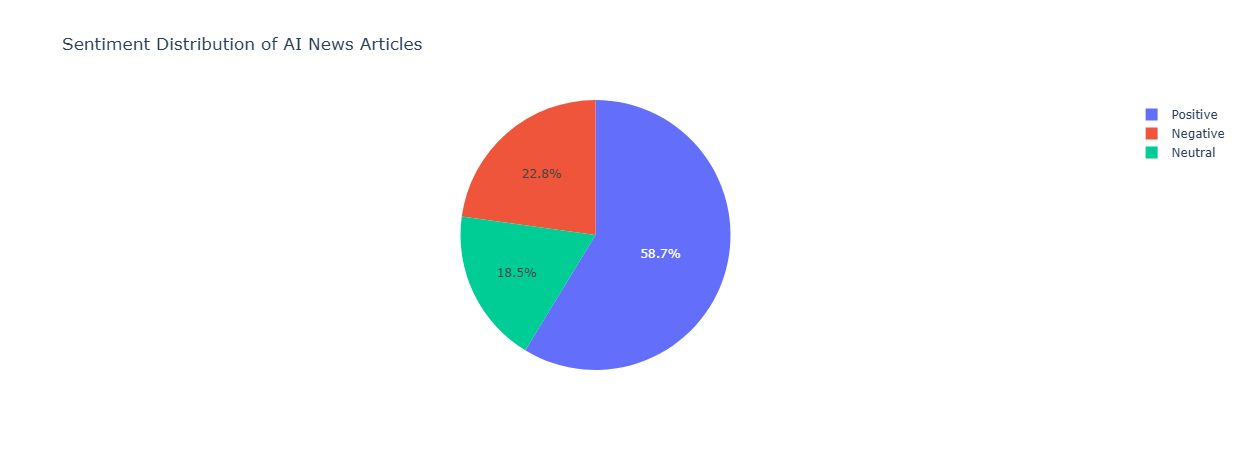
(As of 11/22/2025)

# Pie Chart (12/6/2025)
However, upon running the code on 12/6/2025, the percentages had shifted more to a more negative-neutral stance.  From observing this change, a better conclusion could be that it takes a bit longer for media sentiment to reflect the changes in the market.

In [ ]:
#Pie Chart

df_tones = pd.DataFrame({"Tone": ["Positive", "Negative", "Neutral"],
                         "Count": [positive_count,negative_count,neutral_count]
                         })

tone_pie = px.pie(df_tones, names = "Tone", values = "Count", title = "Sentiment Distribution of AI News Articles")
tone_pie.show()

# Conclusion
Regardless of what the pie charts are showing whether there is lag in the media, or if it reflects something entirely different from the markets, it is important that the media stays on top of informing the public. Public perception drives how urgent an issue feels to policymakers, and when that risk is downplayed, leaders are less likely to prioritize regulations.

# Term-Frequency
Finally, to round off my project, I wanted to look at the term frequencies between all categories. From the word cloud created from each category, I chose a word to focus on, and found out its implications on policymakers.

In [ ]:
# Term Frequency and Vectoring

#Combine All Text Together (ChatGPT Recommended)

df["Combined Text"] = df["title"]

df_tone = df["Tone"]
df_combined = df["Combined Text"]

df_freq = pd.concat([df["Tone"],df["Combined Text"]],axis = 1)

#Seperate by Tone

df_pos = df_freq[df_freq["Tone"] == "positive"]
df_neg = df_freq[df_freq["Tone"] == "negative"]
df_neu = df_freq[df_freq["Tone"] == "neutral"]

vectorizer = TfidfVectorizer(stop_words = 'english')

**Positive**

Crypto – Cryptocurrency and AI have a very similar come up into the space. With the lack of regulation in cryptocurrencies, it was to be expected that AI would eventually be intermingled with crypto. From websites like [pump.fun](https://pump.fun/), we can see that people are taking advantage of the unregulated landscape of both cryptocurrencies and AI to make a quick dollar. It makes sense that crypto would be in the positive section as the media most likely wants to focus on the potentials rather than the risk of the crypto market.


In [ ]:
#Positive
pos_tfidf = vectorizer.fit_transform(df_pos["Combined Text"]) #Fit transform instead of transform b/c we are looking at them seperately
pos_word_scores = np.asarray(pos_tfidf.sum(axis=0)).flatten()
pos_names = np.array(vectorizer.get_feature_names_out())

pos_word_scores = list(zip(pos_names, pos_word_scores))

positive_filter = []
for word,score in pos_word_scores:
    if len(word) > 3:
        positive_filter.append((word,score))
# Sort by score, highest first
pos_word_scores_sorted = sorted(positive_filter, key=lambda x: x[1], reverse=True)

# Take top 20
pos_table = pos_word_scores_sorted[:100]
pos_table

[('europe', np.float64(0.984509061001418)),
 ('crypto', np.float64(0.809800201803399)),
 ('trump', np.float64(0.744183095140037)),
 ('states', np.float64(0.6981137753489738)),
 ('privacy', np.float64(0.6943413200473463)),
 ('nice', np.float64(0.6752382894812007)),
 ('help', np.float64(0.5910414481817448)),
 ('regulation', np.float64(0.5366255458925432)),
 ('billionaires', np.float64(0.5)),
 ('contributions', np.float64(0.5)),
 ('growing', np.float64(0.5)),
 ('political', np.float64(0.5)),
 ('landmark', np.float64(0.46782667816350193)),
 ('laws', np.float64(0.46782667816350193)),
 ('scaling', np.float64(0.46782667816350193)),
 ('converged', np.float64(0.4312968002538629)),
 ('rapidly', np.float64(0.4312968002538629)),
 ('stagnating', np.float64(0.4312968002538629)),
 ('united', np.float64(0.4312968002538629)),
 ('2024', np.float64(0.4181892674494115)),
 ('2026', np.float64(0.4181892674494115)),
 ('angling', np.float64(0.4181892674494115)),
 ('ethical', np.float64(0.4018288315634501)),
 

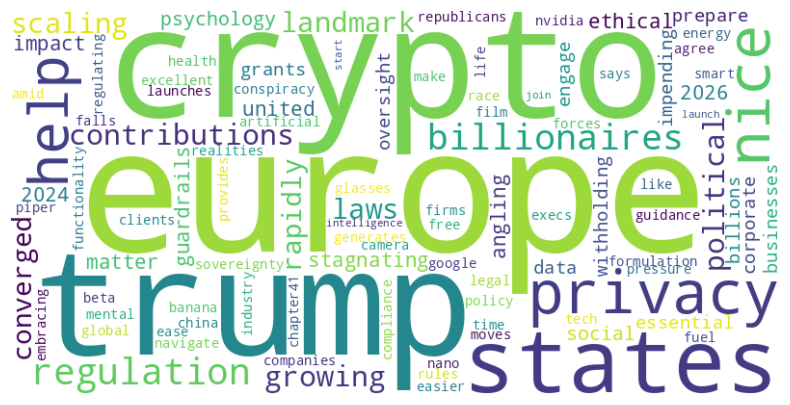

In [ ]:
pos_freq_dict = {word: score for word, score in pos_table}

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words = 100000
).generate_from_frequencies(pos_freq_dict)

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Negative**

Roblox – With the game already having a very negative reputation by being a hub for many child predators, with the introduction of AI comes the risk of deepfakes and blackmail. While the company has offered a new “[AI-powered age estimation process](https://www.cnn.com/2025/11/18/tech/roblox-ai-age-verification-youth-safety),” it brings to light the need to address privacy and safety laws in relation to AI and children’s game.


In [ ]:
#Negative
neg_tfidf = vectorizer.fit_transform(df_neg["Combined Text"])
neg_word_scores = np.asarray(neg_tfidf.sum(axis=0)).flatten()
neg_names = np.array(vectorizer.get_feature_names_out())

neg_word_scores = list(zip(neg_names, neg_word_scores))

negative_filter = []
for word,score in neg_word_scores:
    if len(word) > 3:
        negative_filter.append((word,score))

# Sort by score, highest first
neg_word_scores_sorted = sorted(negative_filter, key=lambda x: x[1], reverse=True)

# Take top 20
neg_table = neg_word_scores_sorted[:100]
neg_table

[('problem', np.float64(1.1133873595777863)),
 ('trump', np.float64(0.9856411169246838)),
 ('states', np.float64(0.9337633905663927)),
 ('duty', np.float64(0.9067816354605722)),
 ('fight', np.float64(0.797190593399669)),
 ('roblox', np.float64(0.7611079684341124)),
 ('regulating', np.float64(0.7516692949598207)),
 ('congressman', np.float64(0.7446929829129822)),
 ('democracy', np.float64(0.722044733050745)),
 ('order', np.float64(0.6833281106406884)),
 ('regulation', np.float64(0.6808434127469898)),
 ('crash', np.float64(0.6608501499082227)),
 ('black', np.float64(0.6404850401763686)),
 ('state', np.float64(0.6108312859800604)),
 ('children', np.float64(0.5773502691896258)),
 ('unavoidable', np.float64(0.5773502691896258)),
 ('violence', np.float64(0.5773502691896258)),
 ('search', np.float64(0.5656191601250365)),
 ('symptom', np.float64(0.5280354636246029)),
 ('worse', np.float64(0.5280354636246029)),
 ('just', np.float64(0.5177225594442122)),
 ('brewing', np.float64(0.513942047241683

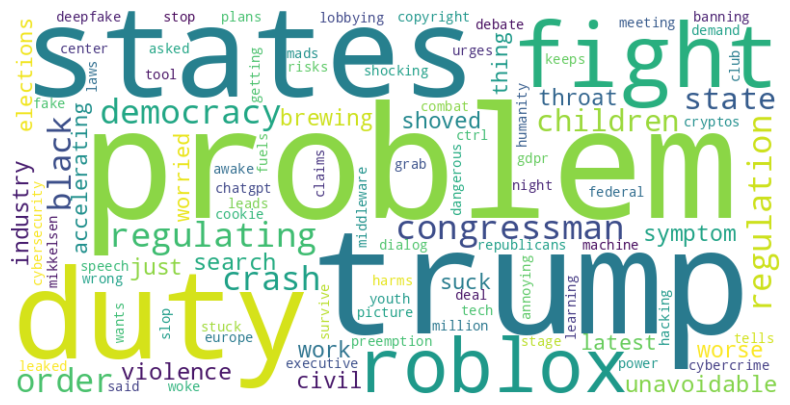

In [ ]:
neg_freq_dict = {word: score for word, score in neg_table}

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
        max_words = 100000
).generate_from_frequencies(neg_freq_dict)

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**Neutral**

Data – Data has always been at the forefront of AI discussions. While there are many cases where AI has helped with data collection, there are also moments where AI collecting our data without us being aware. This brings up a potential policy to focus on: Transparency.


In [ ]:
#Neutral
neu_tfidf = vectorizer.fit_transform(df_neu["Combined Text"])
neu_word_scores = np.asarray(neu_tfidf.sum(axis=0)).flatten()
neu_names = np.array(vectorizer.get_feature_names_out())

neu_word_scores = list(zip(neu_names, neu_word_scores))

neutral_filter = []
for word,score in neu_word_scores:
    if len(word) > 3:
        neutral_filter.append((word,score))

# Sort by score, highest first
neu_word_scores_sorted = sorted(neutral_filter, key=lambda x: x[1], reverse=True)

# Take top 20
neu_table = neu_word_scores_sorted[:100]
neu_table

[('regulation', np.float64(2.0494450271607074)),
 ('trump', np.float64(1.6463240313710774)),
 ('wants', np.float64(1.2467904700844157)),
 ('china', np.float64(1.0778408236376424)),
 ('britain', np.float64(0.8818327816004746)),
 ('economy', np.float64(0.8818327816004746)),
 ('hours', np.float64(0.8818327816004746)),
 ('reboot', np.float64(0.8818327816004746)),
 ('weeks', np.float64(0.8818327816004746)),
 ('data', np.float64(0.8550848284603214)),
 ('state', np.float64(0.8407256333923401)),
 ('right', np.float64(0.8047730855951241)),
 ('crypto', np.float64(0.7951496476229175)),
 ('states', np.float64(0.7858492609229161)),
 ('water', np.float64(0.7420813423398074)),
 ('privacy', np.float64(0.7324337903251079)),
 ('tech', np.float64(0.6956837581214369)),
 ('executive', np.float64(0.6903940882852928)),
 ('order', np.float64(0.6903940882852928)),
 ('divided', np.float64(0.6872047223722002)),
 ('maga', np.float64(0.6872047223722002)),
 ('push', np.float64(0.682943159480741)),
 ('world', np.flo

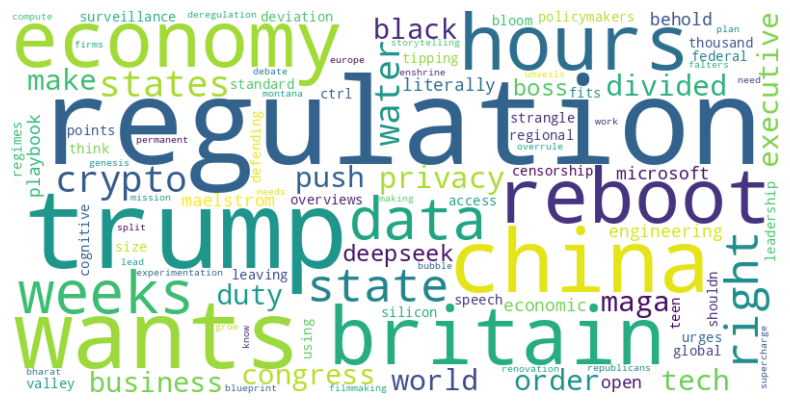

In [ ]:
neu_freq_dict = {word: score for word, score in neu_table}

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white",
    max_words = 100000
).generate_from_frequencies(neu_freq_dict)

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Next Steps

I hope to work further on this project to work on further clearing up the noise in both the term frequency analysis and the sentiment analysis. I believe that some articles may still be misclassified as sentiment analysis may overvalue a word or miss sarcasm. In the case of frequency analysis the best way I could come up with getting rid of noise was only focusing on words that had a length greater than three. While it certainly got rid of words like "Mr", there is definitely better filters that I hope to learn in the future.

[GitHub Notebook Url](https://github.com/sf3318/text-analysis-final/blob/main/final_project_sf3318.ipynb)